<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</style></h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">LABORATORIUM</style></h1>
    <h1 style = "font-size:24px">Głębokie Przetwarzanie Tekstu i Sygnału Mowy
</style></h1>
    <h1 style = "font-size:24px">LAB 09 - Transfer Stylu</style></h1>
    <h1 style = "font-size:24px">Przemysław Rośleń</style></h1>
    
   
</center>LAB
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

#Transfer stylów

W tym laboratorium zajmiemy się techniką transferu stylów. W tej technice wejściem do algorytmu są dwa obrazy:

*   obraz źródłowy, zawartości (*ang. content image*)
*   źrodło stylu (*ang. style image*)

W efekcie otrzymywany jest obraz, którego zawartość odpowiada obrazowi źródłowemu, ale styl obrazu jest zmieniony (zgodnie ze źródłem stylu).

Technika ta ma również wykorzystanie w konwerji głosu gdzie w podobny sposób można dokonywać zmiany stylu czy barwy źródłowej wypowiedzi.

Ćwiczenie składa się zasadniczo z trzech kroków:

1.   Zaimplementowany od podstaw zostanie algorytm transferu stylów co pozwoli na zrozumienie jego działania.
2.   Algorytm ten zostanie przetestowany na wielu obrazach co pozwoli na zrozumienie jego ograniczeń.
3. Przyjrzymy się projektowi konwersji stylów w audio.


#Przygotowanie modelu
W tej częsci zostaną zaimportowane odpowiednie biblioteki i funkcje, wczytane zostaną przykładowe obrazy oraz zadeklarowane zostaną funkcje pomocnicze. Wykorzystany jest tutorial dostępny pod adresem: https://www.tensorflow.org/tutorials/generative/style_transfer

In [ ]:
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
# TODO: zmień RUNTIME na GPU

In [ ]:
import IPython.display as display

import numpy as np
import PIL.Image
import time
import functools

In [ ]:

#większe zrozumienie sposobu w jaki działają sieci CNN,

#umiejętność generowania przykładów mylących# funkcje pomocnicza
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
content_path = tf.keras.utils.get_file('dog.jpg', 'https://farm3.staticflickr.com/2693/4338295020_4082e346b5_z.jpg')
style_path = tf.keras.utils.get_file('scream.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/The_Scream.jpg/470px-The_Scream.jpg')

In [ ]:
def load_img(path_to_img):
    max_dim = 448 #maksymalny rozmiar obrazu
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [ ]:
# funkcje wyświetlania
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.grid'] = False

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

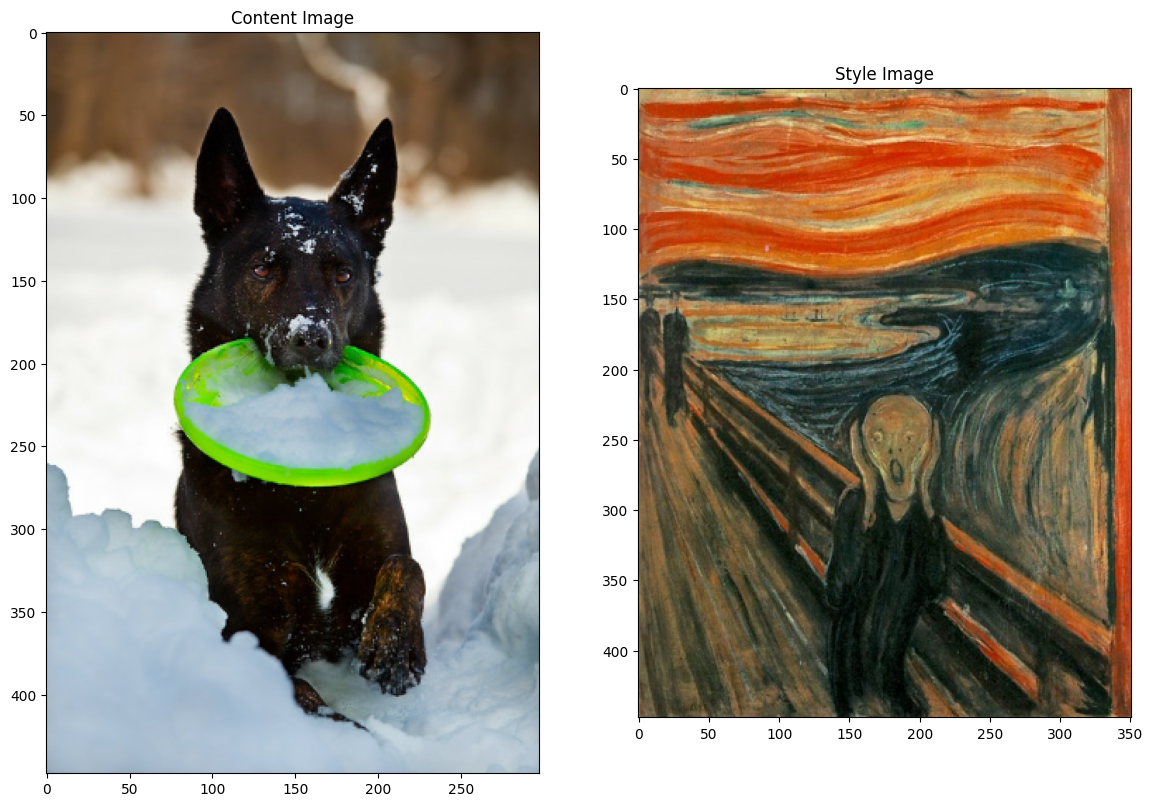

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#Definicja modelu

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
# warstwy sieci neuronowej
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# semantyczny wektor cech
content_layers = ['block5_conv2']
# wektor cech odnośnie stylu, wektory z różnych skal
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  # definicja modelu zwracającego odpowiednie cechy obrazu
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image)

# rozmiary wektora cech
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  rozmiar: ", output.numpy().shape)
    print()

block1_conv1
  rozmiar:  (1, 448, 351, 64)

block2_conv1
  rozmiar:  (1, 224, 175, 128)

block3_conv1
  rozmiar:  (1, 112, 87, 256)

block4_conv1
  rozmiar:  (1, 56, 43, 512)

block5_conv1
  rozmiar:  (1, 28, 21, 512)



In [ ]:
# funkcja obliczająca produkt zewnętrzny (outer product) dla danego tensora
# mówi o tym jak poszczególne wiersze tensora są ze sobą skorelowane
# użyjemy tej funkcji do definicji stylu, ponieważ nie interesuje nas zawartość wektora cech (tym zajmuje się "content loss")
# a korelacja pomiędzy różnymi wierszami tensora

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [ ]:
# klasa obliczająca cech związane ze stylem i zawartością obrazu
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # obliczenie macierzy grama dla kolejnych warstw
        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        # obliczenie wektora zawartości
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styl:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    rozmiar: ", output.numpy().shape)
    print()

print("Zawartość:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    rozmiar: ", output.numpy().shape)


Styl:
   block1_conv1
    rozmiar:  (1, 64, 64)

   block2_conv1
    rozmiar:  (1, 128, 128)

   block3_conv1
    rozmiar:  (1, 256, 256)

   block4_conv1
    rozmiar:  (1, 512, 512)

   block5_conv1
    rozmiar:  (1, 512, 512)

Zawartość:
   block5_conv2
    rozmiar:  (1, 28, 18, 512)


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
random_init = tf.random.uniform(shape=content_image.shape)
image = tf.Variable(random_init)
#image = tf.Variable(content_image)
#print(image.shape)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# współczynniki funkcji kosztu
style_weight=1e-2
content_weight=1e4

# funkcja kosztu
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    # koszt związany ze stylem
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # koszt związany z zawartością obrazu
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Optymalizacja
Zwróć uwagę, że w tym ćwiczeniu optymalizacja odbywa się względem obrazu wejściowego. To znaczy, wartości pikseli obrazu są zmieniane w taki sposób aby zminimalizować wyznaczoną funkcję kosztu.

In [ ]:
# optymalizacja

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

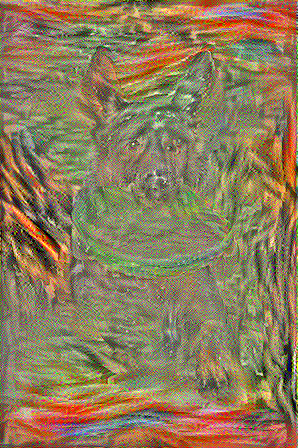

Krok treningowy: 1000
Czas całkowity 55.0


In [ ]:
# Optymalizacja odbywa się w kolejnych krokach.
# Łącznie uruchomimy 1000 kroków z wyświetlaniem efektów co 25 kroków.
import time
start = time.time()

epochs = 40
steps_per_epoch = 25

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Krok treningowy: {}".format(step))

end = time.time()
print("Czas całkowity {:.1f}".format(end-start))

#Zadanie 1 [1 pkt.]
Zwróć uwagę, że powyższym ćwiczeniu optymalizację zaczynaliśmy zaczynając od obrazu źródłowego. Nic nie stoi na przeszkodzie aby optymalizację zacząć od losowego obrazu (np. z losowym szumem). Przeprowadź taki eksperyment. W sprawozdaniu porównaj oba obrazy i zapisz swoje spostrzeżenia.

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
random_init = tf.random.uniform(shape=content_image.shape)
image = tf.Variable(content_image)

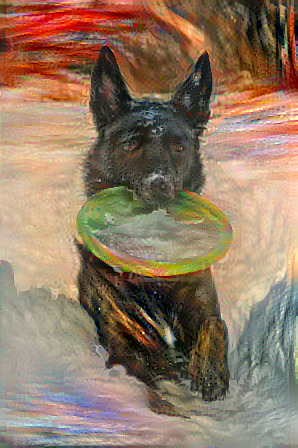

Krok treningowy: 1000
Czas całkowity 55.3


In [ ]:
import time
start = time.time()

epochs = 40
steps_per_epoch = 25

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Krok treningowy: {}".format(step))

end = time.time()
print("Czas całkowity {:.1f}".format(end-start))

#Dalsza optymalizacja
Pewna wadą obecnego modelu jest to, że obrazy wyjściowe posiadają dużą ilośc wysoko-częstotliwościowych artefaktów (szum), przez co krawędzie nie są dobrze widoczne. Aby zapobiec takiemu efektowi można użyc kosztu minimalizującego wariancję sygnału (w tym przypadku wartości pikseli), jest to tzw. filtrowanie wysoko-częstotliwościowe:

https://en.wikipedia.org/wiki/Total_variation_denoising
Dla 1-wymiarowego sygnału jest to po prostu suma różnic sąsiednich elementów w tym sygnale.

Poniżej zaprezentowano wizualizację takiej funkcji kosztu. Jak widać, obraz stylizowany posiada o wiele mniej wyraźnych krawędzi.


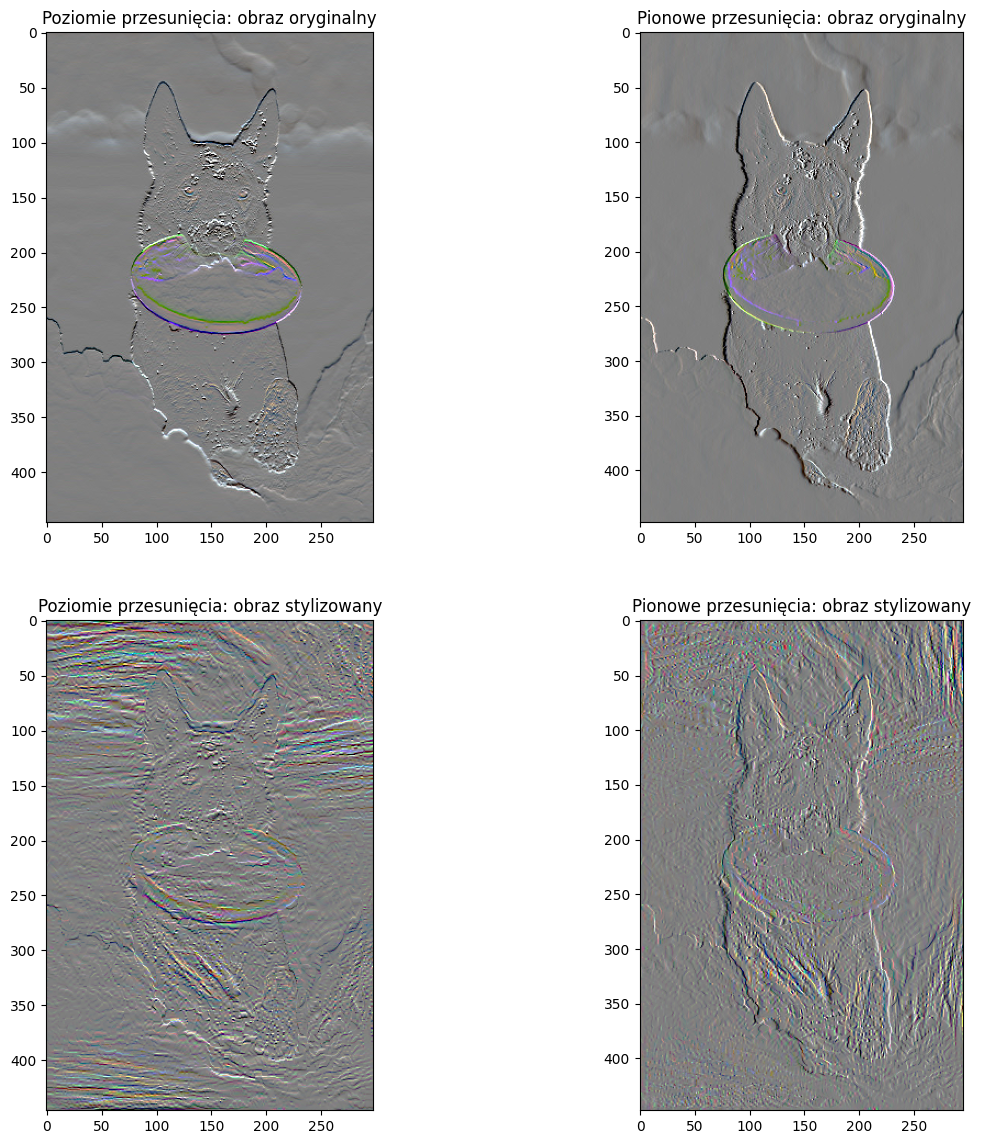

In [ ]:
def high_pass_x_y(image):
    x_var = image[:, :,1:-1, :] - image[:, :, 0:-2, :]
    y_var = image[:, 1:-1, :, :] - image[:, 0:-2, :, :]

    return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 14))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Poziomie przesunięcia: obraz oryginalny")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Pionowe przesunięcia: obraz oryginalny")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Poziomie przesunięcia: obraz stylizowany")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Pionowe przesunięcia: obraz stylizowany")

In [ ]:
#dodanie nowej funkcji kosztu i nowa pętla optymalizacyjna

total_variation_weight=30

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#Zadanie 2 [1 pkt.]
Porównaj działanie nowej funkcji optymalizacji z poprzednią (zaczynając od tego samego obrazu). Jak modyfikacja funkcji kosztu wpłynęła na wynik końcowy? Porównaj zmiany w wysokich częstotliwościach obrazu (zapisz obrazy pokazujące pionowe i poziomie zmiany w sygnale)

#Zadanie 3 [1 pkt.]
Przetestuj powyższy model gdy obrazem od którego rozpoczęta jest optymalizacja jest **zupełnie inny obraz**. Porównaj końcowy efekt optymalizacji.

#Zadanie 4 [3 pkt.]

Przetestuj powyższy model modyfikując (o rząd wielkości) wartości związane z *style_weight* i *content_weight*. W sprawdozdaniu pokaż jak wpłynęło to na końcowy efekt. Zredukuj liczbę kroków (np. do 500) aby nie czekać zbyt długo na końcowe wyniki.

W kolejnym kroku zmień dowolny inny parametr (np. parametr learning rate, wykorzystane warstwy sieci neuronowej, lub **(zadanie z gwiazdką)** użyj innej sieci) i sprawdź jaki ma to wpływ na efekt końcowy.

# Szybki transfer stylów.

Powyższa implementacja transferu stylów pozwoliła na zrozumienie w jaki sposób działa ta metoda, ale ze względu na długi czas optymalizacji nie posiada zbyt dużej wartości praktycznej. W praktyce używa się **szybkiego transferu stylów** (ang. *fast style transfer*), co oznacza, że trenowana jest specjalna sieć neuronowa, która uczy się techniki transferu stylów (**za zbiór treningowy służą obrazy wygenerowanę metodą użytą w tym ćwiczeniu**).

Wiele bibliotek udostępnia już takie wytrenowane modele, które pozwalaja na szybki transfer stylów.





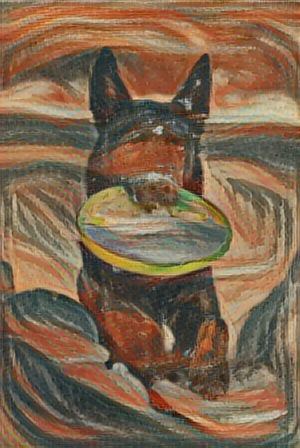

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

#Zadanie 5 [3 pkt.].
Korzystając z techniki szybkiego transferu stylów przetestuj powyższy model dla wielu różnych obrazów (zarówno źrodła zawartości i jak źródła stylu). W sprawozdaniu zapisz swoje obserwacje i podaj przykłady poprawnych i niepoprawnych efektów działania modelu.

Uwaga: korzystając z funkcji tf.keras.utils.get_file, **użyj za każdym razem nowej nazwy** dla zapisywanego pliku (jeśli nazwa nie zostanie zmieniona Keras nie pobierze pliku i nie poinformuje nas o tym). Najlepiej wyświetlać za każdym razem wszystkie 3 obrazy (obraz źródłowy, stylu i efekt końcowy).

In [ ]:
content_path_1 = tf.keras.utils.get_file('szczuko.jpg', 'https://s-trojmiasto.pl/zdj/galeria/111/1016747.jpg')
style_path_1 = tf.keras.utils.get_file('pony.jpg', 'https://s3.mamotoja.pl/newsy/imiona-kucykow-pony-109527-4_3_700.jpg')

content_image_1 = load_img(content_path_1)
style_image_1 = load_img(style_path_1)

In [ ]:
content_path_1 = tf.keras.utils.get_file('dziubich.jpg', 'https://mostwiedzy.pl/assets/tomasz-dziubich,16629-1/photo.png')
style_path_1 = tf.keras.utils.get_file('palpatine.jpg', 'https://static.wikia.nocookie.net/evil/images/d/d8/Emperor_Sidious.png/revision/latest?cb=20200819220152&path-prefix=pl')

content_image_1 = load_img(content_path_1)
style_image_1 = load_img(style_path_1)

In [ ]:
content_path_1 = tf.keras.utils.get_file('vader.jpg', 'https://static.printler.com/cache/e/f/0/c/6/c/ef0c6c257aa3d8b6fa14c82491ddd205c619215d.jpg')
style_path_1 = tf.keras.utils.get_file('dirt.jpg', 'https://i.ytimg.com/vi/1iPNLeHAbrQ/maxresdefault.jpg')

content_image_1 = load_img(content_path_1)
style_image_1 = load_img(style_path_1)

304931/304931 [==============================] - 0s 0us/step


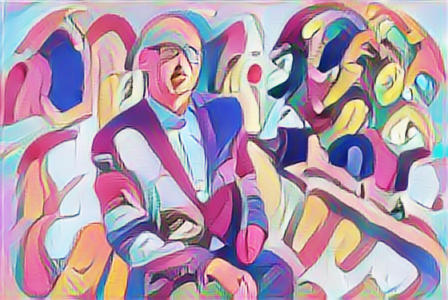

In [ ]:
stylized_image = hub_model(tf.constant(content_image_1), tf.constant(style_image_1))[0]
tensor_to_image(stylized_image)

# Konwersja głosu.

Technikę transferu stylów można oczywiście stosować również w audio. W jednym z artykułów mowa dzielona jest na 4 komponenty (tekst, ton głosu (*pitch*), tembr głosu (*timbre*) oraz rytm (*rhytm*)). Posiadając źródłową wypowiedź oraz wypowiedź docelową, można zmienić zmienić powyższe cechy źródłowej wypowiedzi aby posiadała cechy wypowiedzi docelowej. Inaczej mówiąc, technika ta gdy jest skuteczna, pozwala "włożyć słowa w czyjeś usta".



#Zadanie 6 [1 pkt.]
Zapoznaj się z techniką konwersji głosu dostępną pod adresem https://auspicious3000.github.io/SpeechSplit-Demo/.

Przetestuj model i zapisz swoje obswerwacje. Na ile skuteczną uważasz konwersję głosu i jak oceniasz potencjalne korzyści / zagrożenia z nią związane.